In [1]:
#
#
#

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)

mnist.keys() 

# dict_keys([' data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
# Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (pp. 85-86). O'Reilly Media. Kindle Edition. 

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
type(mnist)

sklearn.utils.Bunch

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s **imshow()** function:

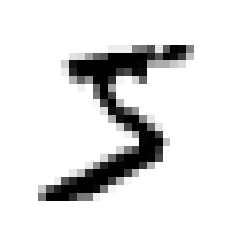

In [5]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 

some_digit = X[0] 
some_digit_image = some_digit.reshape(28, 28) 
plt.imshow(some_digit_image, cmap = "binary") 

plt.axis("off") 
plt.show()

# Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 86). O'Reilly Media. Kindle Edition. 

In [6]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
y[0]

5

But wait! You should always create a test set and set it aside before inspecting the data closely. 
The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [9]:
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, X_test, y_train, y_test = X[:30000], X[65000:], y[:30000], y[65000:]

### Training a binary classifier

In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits 
y_test_5 = (y_test == 5)
print(y_train_5.shape)
print(y_test_5.shape)

(30000,)
(5000,)


In [11]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state = 42) # random_state = 42 to make results reproducable
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

# shuffle=True to avoid warning on random_state
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) 
    X_train_folds = X_train[train_index] 
    y_train_folds = y_train_5[train_index] 
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index] 
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len( y_pred)) # prints 0.9502, 0.96565, and 0.96495
    # for 30000 trainig set: 0.9481 0.9659 0.9655


0.9481
0.9659
0.9655


In [16]:
print(type(skfolds))

<class 'sklearn.model_selection._split.StratifiedKFold'>


In [18]:
list(skfolds.split(X_train, y_train_5))

[(array([    0,     1,     2, ..., 29997, 29998, 29999]),
  array([    4,     6,    13, ..., 29990, 29994, 29996])),
 (array([    0,     1,     2, ..., 29994, 29996, 29999]),
  array([    5,     8,     9, ..., 29995, 29997, 29998])),
 (array([    4,     5,     6, ..., 29996, 29997, 29998]),
  array([    0,     1,     2, ..., 29984, 29993, 29999]))]

Let’s use the <tt>cross_val_score()</tt> function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")


array([0.9458, 0.9634, 0.9603])

In [20]:
# Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? 
# This looks amazing, doesn’t it? Well, before you get too excited, 
# let’s look at a very dumb classifier that just classifies every single image in the “not-5” class: 

from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator): 
    def fit( self, X, y = None): 
        return self 
    def predict(self, X): 
        return np.zeros((len( X), 1), dtype = bool) 
    
# Can you guess this model’s accuracy? Let’s find out: 

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring ="accuracy") 

# array([ 0.91125, 0.90855, 0.90915])

array([0.9137, 0.9088, 0.9066])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix 
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix. 

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the <tt>cross_val_predict()</tt> function:

In [21]:
from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict( sgd_clf, X_train, y_train_5, cv = 3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“ clean” meaning that the prediction is made by a model that never saw the data during training). Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred): 

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) 

#60000: array([[ 53057, 1522], [ 1325, 4096]])
#for 30000: array([[26515, 776], [529, 2180]], dtype=int64)

array([[26515,   776],
       [  529,  2180]], dtype=int64)